# Topic Modeling

### Load Data

In [56]:
# All Imports
import numpy as np  
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

In [57]:
# Load data
df = pd.read_csv(r'/Users/nicohehlke/DataspellProjects/NAK-Text-Analytics/src/data/transfer/cleaned_articles_normalverteilt_3.csv')

### Examine the best amount of topics

In [58]:
# Create a list of all texts
texts = df["Cleaned_Text"].tolist()

# Calculate the term frequency
count_vectorizer = CountVectorizer()
count_matrix = count_vectorizer.fit_transform(texts)

In [9]:
# Prepare for calculation of perplexity for different amounts of topics
numTopicsRange = [5,10,15,20,40,60,80,100,250,500,750,1000]
validationPerplexity = np.zeros(len(numTopicsRange))
timeElapsed = np.zeros(len(numTopicsRange))

numDocuments = len(texts)
train_ratio = 0.9  # Use 90% train data and 10% test data for perplexity
num_train_documents = int(numDocuments * train_ratio)
documentsTrain = texts[:num_train_documents]
documentsValidation = texts[num_train_documents:]

# Calculate perplexity and track elapsed time for all the topic amounts in numTopicsRange
for i in range(len(numTopicsRange)):
    numTopics = numTopicsRange[i]
    start_time = time.time()
    
    lda_model = LatentDirichletAllocation(n_components=numTopics, random_state=1)
    lda_model.fit(count_matrix)
    validationPerplexity[i] = lda_model.perplexity(count_matrix)
    timeElapsed[i] = time.time() - start_time

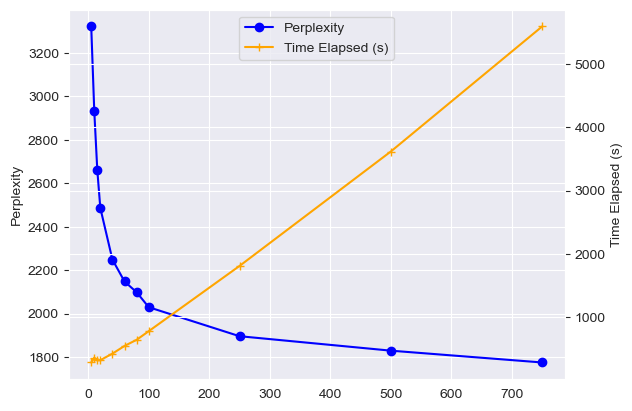

In [10]:
# Create a plot for the elapsed time and validation perplexity depending on the chosen number of topics
plt.figure()
plt.gca().set_prop_cycle(plt.cycler('color', ['b', 'g']))

plt.plot(numTopicsRange[:-1], validationPerplexity[:-1], "o-", label="Perplexity")
plt.ylabel("Perplexity")

plt.twinx()
plt.plot(numTopicsRange[:-1], timeElapsed[:-1], "+-", label="Time Elapsed (s)", color='orange')
plt.ylabel("Time Elapsed (s)")

# Create a legend
legend_elements = [
    Line2D([0], [0], color='b', marker='o', linestyle='-', label='Perplexity'),
    Line2D([0], [0], color='orange', marker='+', linestyle='-', label='Time Elapsed (s)')
]

plt.legend(handles=legend_elements, loc='upper center')
plt.xlabel("Number of Topics")
plt.show()

### Find the most relevant topics

In [59]:
# Create LDA-model
lda_model = LatentDirichletAllocation(n_components=100, random_state=42)
lda_topic_matrix = lda_model.fit_transform(count_matrix)

In [60]:
# Extract the most important word for each topic and use it as a label
feature_names = count_vectorizer.get_feature_names_out()
topic_words = []
for idx, topic in enumerate(lda_model.components_):
    words = [feature_names[i] for i in topic.argsort()[:-1 - 1:-1]]
    topic_words.append(words)
for words in topic_words:
    for i, word in enumerate(words):
        if word == 'eur':
            words[i] = 'euro'
        elif word == 'deu' or word == 'deutschland':
            words[i] = 'deutsch'
print(topic_words)

[['prozent'], ['and'], ['euro'], ['sagen'], ['airbus'], ['prozent'], ['ziel'], ['bedingung'], ['euro'], ['dax'], ['adidas'], ['heidelberg'], ['qiagen'], ['bayer'], ['euro'], ['prozent'], ['lützerath'], ['russland'], ['prozent'], ['deutsch'], ['prozent'], ['prozent'], ['deutsch'], ['sagen'], ['crh'], ['wertpapier'], ['aufsichtsrat'], ['mercedesbenz'], ['fresenius'], ['aktie'], ['ziel'], ['amundi'], ['usa'], ['covestro'], ['siemens'], ['sagen'], ['allzeithoch'], ['porsche'], ['bank'], ['post'], ['prozent'], ['erneuerbar'], ['china'], ['dax'], ['euro'], ['rheinmetall'], ['prozent'], ['mtu'], ['bayer'], ['deutsch'], ['hurrikan'], ['prozent'], ['deutsch'], ['daimler'], ['prozent'], ['sagen'], ['dax'], ['prozent'], ['bank'], ['talanx'], ['unternehmen'], ['prozent'], ['blume'], ['post'], ['mrd'], ['prozent'], ['bank'], ['prozent'], ['prozent'], ['prozent'], ['prozent'], ['wphg'], ['the'], ['euro'], ['china'], ['blackrock'], ['dpaafx'], ['prozent'], ['woche'], ['euro'], ['telekom'], ['porsche'

In [61]:
# dictionary for the mapping of duplicates
mapping_dict = {
    5: 0, 15: 0, 18: 0, 20: 0, 21: 0, 40: 0, 46: 0, 51: 0, 54: 0, 57: 0, 61: 0, 65: 0, 67: 0, 68: 0, 69: 0, 70: 0, 77: 0, 88: 0, 90: 0, 91:0, 94: 0, 8: 2, 14: 2, 44: 2, 73: 2, 79: 2, 84: 2, 23: 3, 35: 3, 55: 3, 43: 9, 56: 9, 22: 19, 49: 19, 52: 19, 98: 19, 58: 38, 66: 38, 30: 6, 48: 13, 97: 29, 81: 37, 63: 39, 74: 42
}
# Find out the most important topic index for each text of the dataFrame
dominant_topics = [np.argmax(topic) for topic in lda_topic_matrix]
for i in range(len(dominant_topics)):
    if dominant_topics[i] in mapping_dict:
        dominant_topics[i] = mapping_dict[dominant_topics[i]]
# Add a new column for the topic index
df['dominant_topic'] = dominant_topics
print(df[['Cleaned_Text', 'dominant_topic']].head())

                                        Cleaned_Text  dominant_topic
0  neu Rumor Porschebörsengang Sixt Berenberg stu...              37
1  Beiersdorf Aktie Kaufempfehlung beflügeln Bere...               7
2  Heidelbergcement klimaneutral Zementwerk Weg B...              99
3  Dax bleiben Rekordhoch Vortag lustlos setzen R...               0
4  Sartorius Impferfolg belasten Papier Laborausr...               2


### Examine the optimal amount of clusters

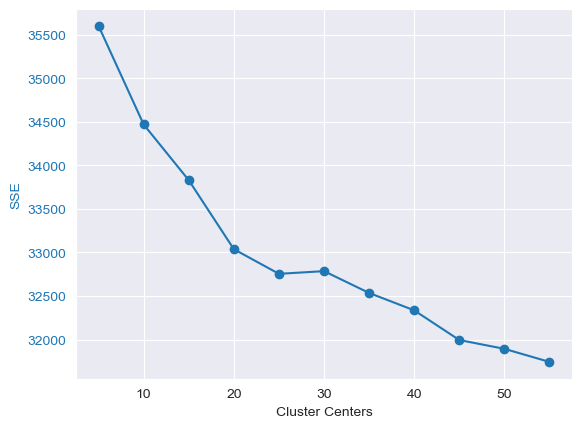

In [55]:
# Calculate the td-idf for cluster creation based on term importance in the collection
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

# Find optimal clusters
iterations = range(5, 60, 5)
sse = []
for k in iterations:
    sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=1).fit(tfidf_matrix).inertia_)

# Plot SSE
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Cluster Centers')
ax1.set_ylabel('SSE', color=color)
ax1.plot(iterations, sse, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.show()

### Map a topic for each cluster

In [62]:
# Create topic-clusters with kMeans
num_clusters = 25
km = KMeans(n_clusters=num_clusters, random_state=1)
km.fit(tfidf_matrix)

# Predict cluster for each text
texte_cluster = km.predict(tfidf_matrix)

In [63]:
# Assign cluster labels to the DataFrame
df['cluster'] = texte_cluster
# Group the DataFrame by cluster and find the most frequent dominant_topic for each cluster
cluster_topics = df.groupby('cluster')['dominant_topic'].apply(lambda x: x.value_counts().idxmax())

# Find the next most frequent dominant_topic if the current value is already in cluster_topics
for cluster, current_dominant_topic in cluster_topics.items():
    count = 1
    while current_dominant_topic in cluster_topics.values:
        next_dominant_topic = df[df['cluster'] == cluster]['dominant_topic'].value_counts().index[count % len(df[df['cluster'] == cluster]['dominant_topic'].value_counts())]
        current_dominant_topic = next_dominant_topic
        count += 1

        # If no free dominant_topic is available, take the most frequent dominant_topic
        if count > len(df[df['cluster'] == cluster]['dominant_topic'].value_counts()):
            current_dominant_topic = df[df['cluster'] == cluster]['dominant_topic'].value_counts().idxmax()
            break

    cluster_topics[cluster] = current_dominant_topic

# Map cluster labels to the unique dominant_topic for each cluster
df['cluster_topic'] = df['cluster'].map(cluster_topics)
# Extract cluster words for each cluster_topic
df['cluster_words'] = df['cluster_topic'].apply(lambda x: topic_words[x][0])
df.to_csv('data//transfer//topic_modeling.csv', index=False)
df.to_excel('data//transfer//topic_modeling.xlsx', index=False)

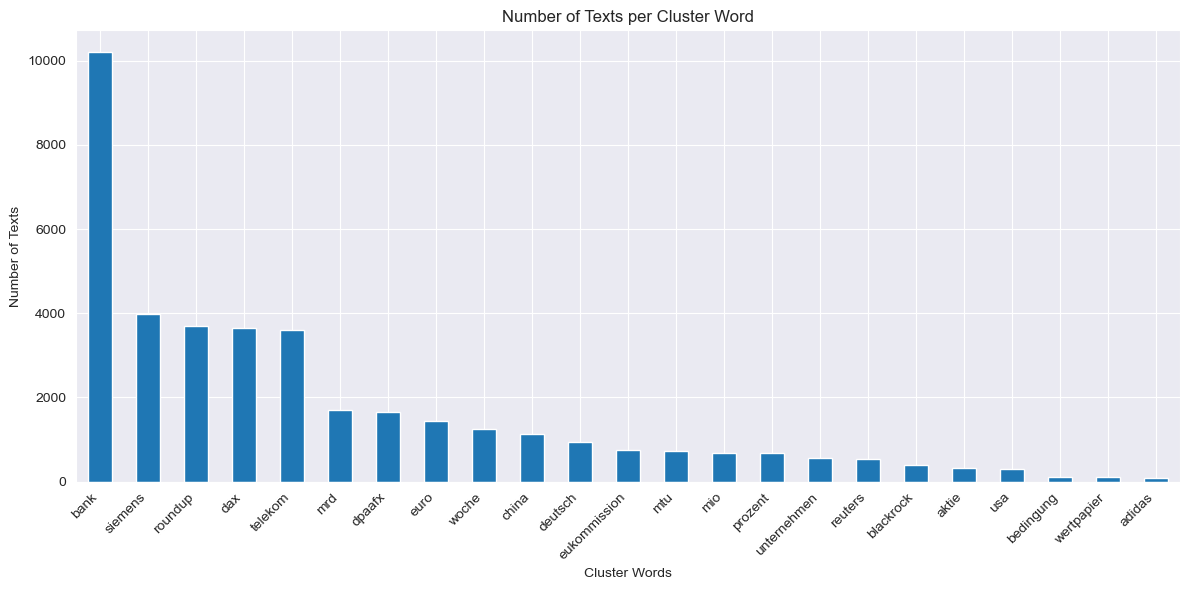

In [66]:
# Bar Chart
# Count amounts of all cluster words
word_counts = df['cluster_words'].value_counts()

# Create a bar chart
plt.figure(figsize=(12, 6))
word_counts.plot(kind='bar')
plt.xlabel('Cluster Words')
plt.ylabel('Number of Texts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()